Run the following cell to clear your processed data folders

In [14]:
!rm -i data_processed/ortho_croped/R_channel/2013/*  -rf

In [2]:
!rm -i data_processed/mnt_croped/2013/*  -rf

In [3]:
!rm -i data_processed/seg_mask_croped/2013/*  -rf

# Data processing

## TIF image cropping

The dataset is composed of three datasource, all TIF image:
- the `ortho_YEAR.tif.ovr`: the satellite picture of the river
- the `shape_YEAR_tif`: the segmentation mask of the bed ofpebbles
- the `mnt_relatif_YEAR.tif`: the blablablabla # TODO

The tif being too large (71618 x 32460 pixels) to be handled in an np.array, we
will create subimage by cropping the original TIFs, and removing the subimages
containing no data (filled with -inf pixel value)

In [1]:
from PIL import Image
import matplotlib.pyplot as plt

Image.MAX_IMAGE_PIXELS = None

In [2]:
img_width = 32460

num_splits_width = []

for i in range(30, 200 + 1):
    if img_width % i == 0:
        num_splits_width.append(i)

num_splits_width

[30, 60]

In [3]:
step_width = img_width / 60
step_width

541.0

We will create 60 vertical splits of 541 px.

In [4]:
img_height = 71618 - 8

num_splits_height = []

for i in range(30, 200 + 1):
    if img_height % i == 0:
        num_splits_height.append(i)

num_splits_height

[30, 31, 33, 35, 42, 55, 62, 66, 70, 77, 93, 105, 110, 154, 155, 165, 186]

In [5]:
step_height = img_height / 186
step_height

385.0

We will create 186 horizontal splits of 385 px

In [6]:
from tqdm import tqdm
import numpy as np

def crop_images(tif_file, tif_cat, output_dir, step_width=541, step_height=385, num_splits_width=60, num_splits_height=186):
    for i in tqdm(range(1, num_splits_width + 1)): # width
        for j in range(1, num_splits_height + 1): # height
            crop_coordinate = ((i-1)*step_width, (j-1)*step_height, i*step_width, j*step_height)
            crop = tif_file.crop(crop_coordinate)
            crop_array = np.array(crop)

            if not len(np.unique(crop_array)) == 1: # toutes les valeurs dans l'array sont -inf ou -3.4028235e+38
                np.save(f'{output_dir}/{tif_cat}_{crop_coordinate}.npy', crop_array)

### Orthophoto

In [7]:
from scipy.ndimage import zoom
import numpy as np
from tqdm import tqdm

# channels = ['R', 'G', 'B']
channels = ['B']

for channel in channels:
    ortho = Image.open(f"data_raw/2013/ortho_2013_{channel}_channel.tif")
    ortho.load()

    print(ortho.height, ortho.width) # l'ortho est deux fois plus petite que les autres TIFS

    ortho = np.array(ortho)

    scale_factor = 2
    upscaled_ortho = zoom(ortho, scale_factor, order=1)  # order=1 for bilinear interpolation

    print(upscaled_ortho.shape)

    del ortho

    for i in tqdm(range(1, 60 + 1)):   # largeur
        for j in range(1, 186 + 1):    # hauteur
            x1 = int((i-1) * step_width)
            y1 = int((j-1) * step_height)
            x2 = int(i*step_width)
            y2 = int(j*step_height)

            crop_array = upscaled_ortho[y1:y2, x1:x2]

            # Vérifie si le crop contient autre chose que des valeurs constantes
            if not np.all(crop_array == crop_array.flat[0]):
                np.save(f'data_processed/ortho_croped/{channel}_channel/2013/ortho_{channel}_channel_({x1}, {y1}, {x2}, {y2}).npy', crop_array)

    del upscaled_ortho

35809 16230
[-3.4028235e+38  1.9000000e+01  2.0000000e+01  2.1000000e+01
  2.2000000e+01  2.3000000e+01  2.4000000e+01  2.5000000e+01
  2.6000000e+01  2.7000000e+01  2.8000000e+01  2.9000000e+01
  3.0000000e+01  3.1000000e+01  3.2000000e+01  3.3000000e+01
  3.4000000e+01  3.5000000e+01  3.6000000e+01  3.7000000e+01
  3.8000000e+01  3.9000000e+01  4.0000000e+01  4.1000000e+01
  4.2000000e+01  4.3000000e+01  4.4000000e+01  4.5000000e+01
  4.6000000e+01  4.7000000e+01  4.8000000e+01  4.9000000e+01
  5.0000000e+01  5.1000000e+01  5.2000000e+01  5.3000000e+01
  5.4000000e+01  5.5000000e+01  5.6000000e+01  5.7000000e+01
  5.8000000e+01  5.9000000e+01  6.0000000e+01  6.1000000e+01
  6.2000000e+01  6.3000000e+01  6.4000000e+01  6.5000000e+01
  6.6000000e+01  6.7000000e+01  6.8000000e+01  6.9000000e+01
  7.0000000e+01  7.1000000e+01  7.2000000e+01  7.3000000e+01
  7.4000000e+01  7.5000000e+01  7.6000000e+01  7.7000000e+01
  7.8000000e+01  7.9000000e+01  8.0000000e+01  8.1000000e+01
  8.2000000e

100%|██████████| 60/60 [00:23<00:00,  2.53it/s]


In [8]:
import os

len(os.listdir('data_processed/ortho_croped/B_channel/2013'))

1298

Il y a trop d'image générées !!! C'est normal car par rapport au mnt l'ortho est plus large => on supprimera les photos d'ortho en trop vu qu'on va chercher à incorporer les deux sources de données au modèle.

### Segmentation mask

In [64]:
## TODO rajouter des shutil pour supprimer les dossiers avant de régénérer les données

In [18]:
seg_mask = Image.open("data_raw/2013/shape_2013_tif.tif")
seg_mask.load()

print(seg_mask.width, seg_mask.height)

# seg_mask = seg_mask.resize((16230, 35809))

# assert(seg_mask.width == 16230)
# assert(seg_mask.height == 35809)

32460 71618


In [19]:
crop_images(seg_mask, 'seg_mask', 'data_processed/seg_mask_croped/2013')

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:52<00:00,  1.15it/s]


In [20]:
import os

seg_mask_crop_dir = 'data_processed/seg_mask_croped/2013'

seg_mask_crop_list = os.listdir(seg_mask_crop_dir)

print(f'{len(seg_mask_crop_list)} images cropées conservées sur {60*186} générées')
print(f'Les images cropées ont la shape suivante : {np.load(f"{seg_mask_crop_dir}/{seg_mask_crop_list[0]}").shape}')

130 images cropées conservées sur 11160 générées
Les images cropées ont la shape suivante : (385, 541)


In [21]:
del seg_mask

### MNT

In [22]:
mnt = Image.open("data_raw/2013/mnt_relatif.tif")
mnt.load()

print(f'Height of the picture: {mnt.height}, width: {mnt.width}')
assert(mnt.width == 32460)
assert(mnt.height == 71618)

##### TODO mettre tous le code de description des caractéristiques des images dans la première section de preprocessing
# print(f'Width of croped img: {32460/60}')
# step_width = int(mnt.width/60)

# print(f'Height of croped img (removing 8 pixels to be able to divide it with int): {(71618-8)/186}')
# setp_height = int((mnt.height-8)/186)

Height of the picture: 71618, width: 32460


In [23]:
crop_images(mnt, 'mnt', 'data_processed/mnt_croped/2013')

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:17<00:00,  3.43it/s]


In [24]:
import os
import numpy as np

mnt_crop_dir = 'data_processed/mnt_croped/2013'

mnt_crop_list = os.listdir(mnt_crop_dir)

print(f'{len(mnt_crop_list)} images cropées conservées sur {60*186} générées')
print(f'Les images cropées ont la shape suivante : {np.load(f"{mnt_crop_dir}/{mnt_crop_list[0]}").shape}')

523 images cropées conservées sur 11160 générées
Les images cropées ont la shape suivante : (385, 541)


In [25]:
del mnt

### Creation of missing segmask

In [26]:
len(seg_mask_crop_list), len(mnt_crop_list)

(130, 523)

Only 130 out of the 523 needed segmasks were creating via cropping, as most of 
the ortho and mnt crops don't have peebles bed on it. Thus, we will create the 
missing segmasks, filled with 0.

In [27]:
seg_mask_crop_dir = 'data_processed/seg_mask_croped/2013'
seg_mask_crop_list = os.listdir(seg_mask_crop_dir)

mnt_crop_dir = 'data_processed/mnt_croped/2013'
mnt_crop_list = os.listdir(mnt_crop_dir)

crop_shape = (385, 541)

for mnt in mnt_crop_list:
    crop_coordinate = mnt.split('_')[-1].split('.')[0]

    seg_mask_exist = False

    for seg_mask in seg_mask_crop_list:
        if crop_coordinate in seg_mask:
            seg_mask_exist = True
            break

    if not seg_mask_exist:
        seg_mask = np.zeros(crop_shape)
        np.save(f'{seg_mask_crop_dir}/seg_mask_{crop_coordinate}.npy', seg_mask)


Let's check that we have the same number of crops and at the same coordinates

In [29]:
seg_mask_crop_dir = 'data_processed/seg_mask_croped/2013'
seg_mask_crop_list = os.listdir(seg_mask_crop_dir)
seg_mask_crop_list.sort()

mnt_crop_dir = 'data_processed/mnt_croped/2013'
mnt_crop_list = os.listdir(mnt_crop_dir)
mnt_crop_list.sort()

assert len(mnt_crop_list) == len(seg_mask_crop_list)

for seg_mask, mnt in zip(seg_mask_crop_list, mnt_crop_list):
    seg_mask_coord = seg_mask.split('_')[-1].split('.')[0]
    mnt_coord = mnt.split('_')[-1].split('.')[0]

    assert seg_mask_coord == mnt_coord

### Suppression of exceeding orthophoto crops

Orthophoto are wider than the mnt. Thus, we have more orthophoto crops than mnt crops. As we plan to use both data as inputs for our model, we will remove the ortho crops without corresponding mnt crops.

In [9]:
ortho_R_channel_crop_dir = 'data_processed/ortho_croped/R_channel/2013'
ortho_R_channel_crop_list = os.listdir(ortho_R_channel_crop_dir)
ortho_R_channel_crop_list.sort()

ortho_G_channel_crop_dir = 'data_processed/ortho_croped/G_channel/2013'
ortho_G_channel_crop_list = os.listdir(ortho_G_channel_crop_dir)
ortho_G_channel_crop_list.sort()

ortho_B_channel_crop_dir = 'data_processed/ortho_croped/B_channel/2013'
ortho_B_channel_crop_list = os.listdir(ortho_B_channel_crop_dir)
ortho_B_channel_crop_list.sort()

mnt_crop_dir = 'data_processed/mnt_croped/2013'
mnt_crop_list = os.listdir(mnt_crop_dir)
mnt_crop_list.sort()

print(f'Number of ortho crops (R, G, B): {len(ortho_R_channel_crop_list)}, {len(ortho_G_channel_crop_list)}, {len(ortho_B_channel_crop_list)}')
print(f'Number of mnt crops: {len(mnt_crop_list)}')

Number of ortho crops (R, G, B): 523, 1298, 1298
Number of mnt crops: 523


In [ ]:
# TODO on all channels !!!!!!! et les regrouper ensuite

In [11]:
ortho_channels_lists = [ortho_R_channel_crop_list, ortho_G_channel_crop_list, ortho_B_channel_crop_list]
ortho_channels_dirs = [ortho_R_channel_crop_dir, ortho_G_channel_crop_dir, ortho_B_channel_crop_dir]

for ortho_crop_list, ortho_crop_dir in zip(ortho_channels_lists, ortho_channels_dirs):
    for ortho in tqdm(ortho_crop_list):
        crop_coordinate = ortho.split('_')[-1].split('.')[0]

        mnt_exist = False

        for mnt in mnt_crop_list:
            if crop_coordinate in mnt:
                mnt_exist = True
                break

        if not mnt_exist:
            os.remove(f'{ortho_crop_dir}/{ortho}')

  0%|          | 0/523 [00:00<?, ?it/s]

100%|██████████| 1298/1298 [00:00<00:00, 4553.34it/s]


In [ ]:
# reload ortho dir to track file suppression
ortho_R_channel_crop_dir = 'data_processed/ortho_croped/R_channel/2013'
ortho_R_channel_crop_list = os.listdir(ortho_R_channel_crop_dir)
ortho_R_channel_crop_list.sort()

ortho_G_channel_crop_dir = 'data_processed/ortho_croped/G_channel/2013'
ortho_G_channel_crop_list = os.listdir(ortho_G_channel_crop_dir)
ortho_G_channel_crop_list.sort()

ortho_B_channel_crop_dir = 'data_processed/ortho_croped/B_channel/2013'
ortho_B_channel_crop_list = os.listdir(ortho_B_channel_crop_dir)
ortho_B_channel_crop_list.sort()

mnt_crop_dir = 'data_processed/mnt_croped/2013'
mnt_crop_list = os.listdir(mnt_crop_dir)
mnt_crop_list.sort()

print(len(mnt_crop_list), len(ortho_R_channel_crop_list), len(ortho_G_channel_crop_list), len(ortho_B_channel_crop_list))

assert len(mnt_crop_list) == len(ortho_R_channel_crop_list)
assert len(mnt_crop_list) == len(ortho_G_channel_crop_list)
assert len(mnt_crop_list) == len(ortho_B_channel_crop_list)

for ortho_R, ortho_G, ortho_B, mnt in zip(ortho_R_channel_crop_list, ortho_G_channel_crop_list, ortho_B_channel_crop_list, mnt_crop_list):
    ortho_R_coord = ortho_R.split('_')[-1].split('.')[0]
    ortho_G_coord = ortho_G.split('_')[-1].split('.')[0]
    ortho_B_coord = ortho_B.split('_')[-1].split('.')[0]
    mnt_coord = mnt.split('_')[-1].split('.')[0]

    assert mnt_coord == ortho_R_coord
    assert mnt_coord == ortho_G_coord
    assert mnt_coord == ortho_B_coord

523 523 523 523


### Combining ortho channel back in a RGB array

In [31]:
ortho_R_channel_crop_dir = 'data_processed/ortho_croped/R_channel/2013'
ortho_R_channel_crop_list = os.listdir(ortho_R_channel_crop_dir)
ortho_R_channel_crop_list.sort()

ortho_G_channel_crop_dir = 'data_processed/ortho_croped/G_channel/2013'
ortho_G_channel_crop_list = os.listdir(ortho_G_channel_crop_dir)
ortho_G_channel_crop_list.sort()

ortho_B_channel_crop_dir = 'data_processed/ortho_croped/B_channel/2013'
ortho_B_channel_crop_list = os.listdir(ortho_B_channel_crop_dir)
ortho_B_channel_crop_list.sort()

for ortho_R, ortho_G, ortho_B in zip(ortho_R_channel_crop_list, ortho_G_channel_crop_list, ortho_B_channel_crop_list):
    ortho_coord = ortho_R.split('_')[-1].split('.')[0]

    ortho_R_arr = np.load(f'{ortho_R_channel_crop_dir}/{ortho_R}')
    ortho_G_arr = np.load(f'{ortho_G_channel_crop_dir}/{ortho_G}')
    ortho_B_arr = np.load(f'{ortho_B_channel_crop_dir}/{ortho_B}')

    RGB_array = np.transpose([np.uint8(ortho_R_arr), np.uint8(ortho_G_arr), np.uint8(ortho_B_arr)], (1, 2, 0))
    np.save(f'data_processed/ortho_croped/RGB/2013/ortho_RGB_2013_{ortho_coord}.npy', RGB_array)

/tmp/ipykernel_55337/2739591242.py:20: RuntimeWarning: invalid value encountered in cast
  RGB_array = np.transpose([np.uint8(ortho_R_arr), np.uint8(ortho_G_arr), np.uint8(ortho_B_arr)], (1, 2, 0))


In [32]:
len(os.listdir('data_processed/ortho_croped/RGB/2013'))

523

### Checking data type

#### Seg masks

In [30]:
import pandas as pd

seg_mask_dict = {}

for seg_mask in seg_mask_crop_list:
    unique_ids = np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask}'))
    if len(unique_ids) in seg_mask_dict.keys():
        seg_mask_dict[len(unique_ids)] += 1
    else:
        seg_mask_dict.update({len(unique_ids): 1})

In [31]:
df = pd.DataFrame.from_dict(seg_mask_dict, orient='index').reset_index()
df.columns = ["number_of_peebles_bed", "number_of_croped_seg_mask"]
df['number_of_peebles_bed'] -= 1
df.sort_values(by='number_of_croped_seg_mask', ascending=False)

,number_of_peebles_bed,number_of_croped_seg_mask
1,0,393
0,1,85
2,2,35
3,3,8
4,4,2


The vast majority of segmask don't have any peebles - this a point to keep in mind during training.

Let's check the array of the some segmentation masks

In [32]:
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[7]}')))
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[8]}')))
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[17]}')))
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[330]}')))

[ 0 76 77]
[ 0 76]
[ 0 75]
[0.]


in the instance annotation masks, the R(ed) channel encodes category ID, and the G(reen) channel encodes instance ID. Each object instance has a unique instance ID regardless of its category ID.
So we should :
- create a new channel to encode category ID, that will be our first channel (Red)
- pass the actual ids into the second channel (Green)
- create a third channel full of 0 (Blue)

In [33]:
import os
import numpy as np

for seg_mask in seg_mask_crop_list:
    G_channel = np.load(f'{seg_mask_crop_dir}/{seg_mask}')
    R_channel = np.where(G_channel > 0, 1, G_channel)
    B_channel = np.zeros_like(G_channel)

    three_channel_arr = np.array([R_channel, G_channel, B_channel])

    np.save(f'{seg_mask_crop_dir}/{seg_mask}', three_channel_arr)

In [34]:
print('############')
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[7]}')[0]))
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[7]}')[1]))
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[7]}')[2]))
print('############')
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[8]}')[0]))
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[8]}')[1]))
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[8]}')[2]))
print('###########')
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[17]}')[0]))
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[17]}')[1]))
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[17]}')[2]))
print('###########')
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[330]}')[0]))
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[330]}')[1]))
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[330]}')[2]))
print('###########')

############
[0 1]
[ 0 76 77]
[0]
############
[0 1]
[ 0 76]
[0]
###########
[0 1]
[ 0 75]
[0]
###########
[0.]
[0.]
[0.]
###########


We have now the category ID on our first channel (Red), the instance ID in the second channel (Green) and nothing on the third one (Blue).

#### Mnt

Let's laod a croped mnt

In [35]:
mnt = np.load(f'{mnt_crop_dir}/{mnt_crop_list[0]}')

np.min(np.unique(mnt))

np.float32(-3.4028235e+38)

In [37]:
real_min = 0

for mnt in mnt_crop_list:
    mnt_arr = np.load(f'{mnt_crop_dir}/{mnt}')
    mnt_min = np.min(mnt_arr[mnt_arr > -1e6])
    if mnt_min < real_min:
        real_min = mnt_min

real_min

np.float32(-4.151123)

There is some `-inf` value where the mnt was not calculated. The real min is `-4.15`. We will replace these `-inf` values by `np.nan`. Also, these files have only one channel, our the model inputs has to have 3 channels, we will thus expand our array dims.

In [38]:
for mnt in mnt_crop_list:
    mnt_arr = np.load(f'{mnt_crop_dir}/{mnt}')
    mnt_arr = np.where(mnt_arr < -10, np.nan, mnt_arr)
    mnt_arr = np.array([mnt_arr]*3)
    np.save(f'{mnt_crop_dir}/{mnt}', mnt_arr)

## Visualisation

In [78]:
#### TODO savoir cb j'ai de lit de caillou segmenté au total

In [33]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np

ortho_crop_dir = 'data_processed/ortho_croped/RGB/2013'
ortho_crop_list = os.listdir(ortho_crop_dir)

seg_mask_crop_dir = 'data_processed/seg_mask_croped/2013'
seg_mask_crop_list = os.listdir(seg_mask_crop_dir)

mnt_crop_dir = 'data_processed/mnt_croped/2013'
mnt_crop_list = os.listdir(mnt_crop_dir)

ortho_crop_list.sort()
seg_mask_crop_list.sort()
mnt_crop_list.sort()

In [34]:
id_of_crops_with_pebble_bed = []

for idx, label in enumerate(seg_mask_crop_list):
  label_arr = np.load(f'{seg_mask_crop_dir}/{label}')
  if np.sum(label_arr) > 0:
    id_of_crops_with_pebble_bed.append(idx)

len(id_of_crops_with_pebble_bed)

130

In [35]:
def rescale_instance_id(G_channel):
    num_instance = len(np.unique(G_channel))
    colors = np.uint8(np.linspace(0, 255, num_instance))[1:]
    return colors

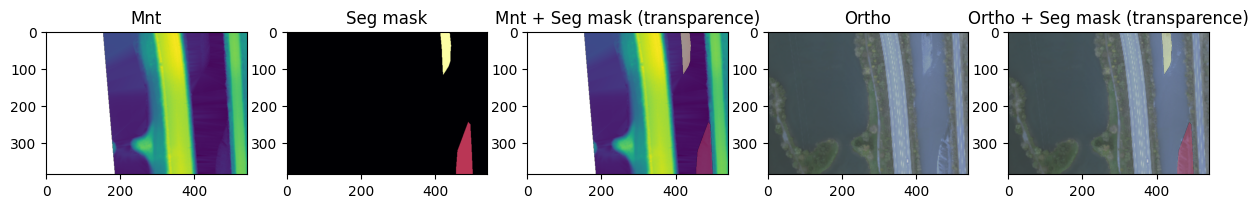

In [42]:
import matplotlib.cm as cm

idx = id_of_crops_with_pebble_bed[33]

ortho = np.load(f'{ortho_crop_dir}/{ortho_crop_list[idx]}')
seg_mask = np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[idx]}')
mnt = np.load(f'{mnt_crop_dir}/{mnt_crop_list[idx]}')

seg_mask_R_channel = seg_mask[0]
seg_mask_G_channel = seg_mask[1]

colors = rescale_instance_id(seg_mask_G_channel)

for color, id in zip(colors, np.unique(seg_mask_G_channel)[1:]):
    seg_mask_G_channel = np.where(seg_mask_G_channel == id, color, seg_mask_G_channel)

f, axarr = plt.subplots(1,5)
f.set_figheight(15)
f.set_figwidth(15)

axarr[0].imshow(mnt[0])
axarr[0].set_title("Mnt")

axarr[1].imshow(seg_mask_G_channel, cmap='inferno')
axarr[1].set_title("Seg mask")

mask = seg_mask_G_channel != 0

axarr[2].imshow(mnt[0])
axarr[2].imshow(np.ma.masked_where(~mask, seg_mask_G_channel),
                cmap=cm.inferno, alpha=0.5, vmin=0, vmax=255)
axarr[2].set_title("Mnt + Seg mask (transparence)")

axarr[3].imshow(ortho)
axarr[3].set_title("Ortho")

axarr[4].imshow(ortho)
axarr[4].imshow(np.ma.masked_where(~mask, seg_mask_G_channel),
                cmap=cm.inferno, alpha=0.5, vmin=0, vmax=255)
axarr[4].set_title("Ortho + Seg mask (transparence)");

In [18]:
highest_bed_id = 0

for seg_mask in seg_mask_crop_list:
    mask = np.load(f'{seg_mask_crop_dir}/{seg_mask}')
    mask_G_channel = mask[1]
    max_id = np.max(mask_G_channel)
    if max_id > highest_bed_id:
        highest_bed_id = max_id

highest_bed_id

np.uint8(160)

In all our data, 160 pebble beds were labeled, and are present across 130 croped images.